# Detecting Brain Tumors in MRIs using State of the Art (SOTA) Sequential Models

In [8]:
import matplotlib.pyplot as plt
import yaml
import os
import torch
import cv2
import gc
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.v2 import functional as F
from torchvision.ops.boxes import box_area
from torchvision.ops.boxes import box_convert
from glob import glob
from pathlib import Path
from tqdm.auto import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.display import Image, display
from PIL import Image as PILImage, ImageDraw
from torchvision.ops import nms
import torch.nn as nn
import numpy as np

BATCHSIZE_TRAINLOADER = 8
BATCHSIZE_TESTLOADER = 1
OUT_DIR = "data/output/"

## Data Preparation

Restricting the amount of images to use during training due to computational constraints.

In [9]:
import os

def delete_files_in_folder(folder_path, keep_count):
    images_path = '/images'
    labels_path = '/labels'
    
    images = os.listdir(folder_path + images_path)
    
    num_files_to_delete = len(images) - keep_count
    
    if num_files_to_delete <= 0:
        print("The number of files is less than or equal to the specified keep count.")
        return
    
    print(f"Deleting {num_files_to_delete} files.")
    
    for i in range(num_files_to_delete):
        image_name = images[i]
        label_name = os.path.splitext(image_name)[0] + '.txt'
        image_to_delete = os.path.join(folder_path + images_path, image_name)
        label_to_delete = os.path.join(folder_path + labels_path, label_name)

        if os.path.exists(image_to_delete):
            os.remove(image_to_delete)
        else:
            print(f"Image not found: {image_to_delete}")
            
        if os.path.exists(label_to_delete):
            os.remove(label_to_delete)
        else:
            print(f"Label not found: {label_to_delete}")

In [10]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

delete_files_in_folder(train_path, 1000)
delete_files_in_folder(valid_path, 350)
delete_files_in_folder(test_path, 150)

The number of files is less than or equal to the specified keep count.
The number of files is less than or equal to the specified keep count.
The number of files is less than or equal to the specified keep count.


In [11]:
dataset_path = 'data/'
os.listdir(dataset_path)

['model9.pth',
 'valid_loss_6.png',
 'valid',
 'test',
 'valid_loss_3.png',
 'valid_loss_12.png',
 'train_loss_12.png',
 'train_loss_9.png',
 'train_loss_15.png',
 'valid_loss_15.png',
 'train_loss_3.png',
 'data.yaml',
 'train_loss_6.png',
 'train',
 'README.txt',
 'model15.pth',
 'model3.pth',
 'model6.pth',
 'valid_loss_9.png',
 'model12.pth']

In [12]:
with open(os.path.join(dataset_path, 'data.yaml'), "r") as stream:
    data = yaml.safe_load(stream)

data

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 3,
 'names': ['label0', 'label1', 'label2'],
 'roboflow': {'workspace': 'yousef-ghanem-jzj4y',
  'project': 'brain-tumor-detection-fpf1f',
  'version': 2,
  'license': 'Public Domain',
  'url': 'https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f/dataset/2'}}

# Data processing

In [59]:
class PreprocessData(torch.utils.data.Dataset):
    def __init__(self, root, width, height, transforms=None):
        self.root = root
        self.transforms = transforms
        self.width = width
        self.height = height
        self.images = glob(os.path.join(root, "images", "*"))
        self.labels = []
    
        for image_path in self.images:
            filename_with_ext = image_path.split("/")[-1] 
            filename = ".".join(filename_with_ext.split(".")[:-1]) 
            label_path = os.path.join(root, "labels", f"{filename}.txt")
            self.labels.append(label_path)
    
        labels = glob(os.path.join(root, "labels", "*.txt"))
        assert sorted(self.labels) == sorted(labels)
    
        _labels = []
        indices_to_be_removed = []
        bar = tqdm(enumerate(self.labels), desc="Processing labels", total=len(self.labels))
        for idx, label in bar:
            processed_label = self.process_labels_file(label)
            if processed_label[0] == [""]:
                indices_to_be_removed.append(idx)
            else:
                _labels.append(processed_label)
            
            bar.set_description(desc=f"Processing labels, deficit: {len(indices_to_be_removed)}")
        
        self.labels = _labels
        for k, idx in enumerate(indices_to_be_removed, 1):
            del self.images[idx-k]

    def read_file(self, path: Path) -> str:
        with open(path, "r") as f:
            return f.read()
                    
    def process_labels_file(self, path: Path) -> str:
        labels = self.read_file(path)
        labels = labels.split("\n")
        labels = [label.split(" ") for label in labels]
        bboxes = [label[1:] for label in labels]
        labels = [label[0] for label in labels]
        return labels, bboxes

    def process_labels(self, labels_list: list, bboxes_list: list, h: int, w: int) -> torch.Tensor:
        label_indices = []
        bboxes = []
        for label, bbox in zip(labels_list, bboxes_list):
            l = int(label)
            cx, cy, bw, bh = list(map(float, bbox))
            bbox = [cx*w, cy*h, bw*w, bh*h]
            bbox = torch.Tensor(bbox)
            bbox = box_convert(bbox, in_fmt="cxcywh", out_fmt="xyxy")
            label_indices.append(l)
            bboxes.append(bbox)
                          
        labels = torch.tensor(label_indices).to(torch.int64)
        bboxes = torch.vstack(bboxes).to(torch.float32)
        
        return labels, bboxes

    def __getitem__(self, idx):
        image_path = self.images[idx]
        labels, bboxes = self.labels[idx]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        w, h = self.width, self.height
        labels, bboxes = self.process_labels(labels, bboxes, h, w)
                      
        iscrowd = torch.zeros((labels.size(0), ), dtype=torch.int64)
        image_id = idx
        area = box_area(bboxes)

        target = {
            "boxes": tv_tensors.BoundingBoxes(bboxes, format="XYXY", canvas_size=[h,w]),
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
            "image_id": image_id
        }

        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target

    def __len__(self) -> int: return len(self.images)

## Data Augmentations


In [61]:
from torchvision.transforms import v2 as T
import torchvision.transforms as transforms

def training_data_augmentations():
 return A.Compose([
        A.Flip(0.5, always_apply=True),
        A.RandomRotate90(0.5, always_apply=True),
        A.MotionBlur(p=0.2, always_apply=True),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def training_data_more_augmentations():
    return A.Compose([
        A.Flip(p=0.5, always_apply=False),  
        A.RandomRotate90(p=0.5, always_apply=False),  
        A.MotionBlur(p=0.2, always_apply=False),  
        A.MedianBlur(blur_limit=3, p=0.1, always_apply=False), 
        A.Blur(blur_limit=3, p=0.1, always_apply=False),  
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3, always_apply=False),  
        A.GaussNoise(p=0.2, always_apply=False),  
        A.HorizontalFlip(p=0.5, always_apply=False),  
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.3, always_apply=False),  
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3, always_apply=False),  
        ToTensorV2(p=1.0, always_apply=True),  
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

# No actual data augmentation performed
def validation_data_augmentations():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

training_data_transformed = PreprocessData(os.path.join(dataset_path, "train"), height = 125, width=125, transforms = training_data_augmentations())
training_data_more_transformed = PreprocessData(os.path.join(dataset_path, "train"), height = 125, width=125, transforms = training_data_more_augmentations())
training_data_nottransformed = PreprocessData(os.path.join(dataset_path, "train"), height = 125, width=125)




Processing labels:   0%|          | 0/50 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/50 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/50 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/7 [00:00<?, ?it/s]

Boxes: tensor([[ 60.2518,  65.3409, 104.3165,  93.7500],
        [  4.4964,  20.8333, 118.7050, 107.0076],
        [ 66.5468,  65.3409, 105.2158,  94.6970]])
Labels: [0 1 2]
Label: ['0', '1', '2']


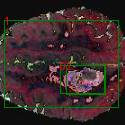

Boxes: tensor([[ 68.3453,  74.8106,  91.7266,  96.5909],
        [ 69.2446,  74.8106, 101.6187, 116.4773],
        [ 65.6475,  72.9167,  90.8273, 104.1667]])
Labels: [0 1 2]
Label: ['0', '1', '2']


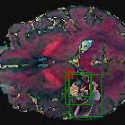

Boxes: tensor([[102.5180,  72.9167, 118.7050,  86.1742]])
Labels: [1]
Label: ['1']


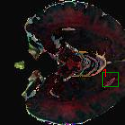

Boxes: tensor([[ 46.7626,  21.7803,  87.2302,  53.0303],
        [ 24.2806,   1.8939, 107.9137,  60.6061]])
Labels: [0 1]
Label: ['0', '1']


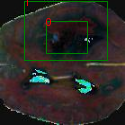

Boxes: tensor([[ 21.5827,  77.6515,  72.8417, 107.0076],
        [ 17.0863,  69.1288,  87.2302, 111.7424],
        [ 17.9856,  71.0227,  80.9352, 110.7955]])
Labels: [0 1 2]
Label: ['0', '1', '2']


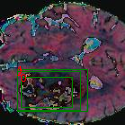

Boxes: tensor([[ 23.3813,  71.0227,  73.7410, 119.3182],
        [ 20.6835,  66.2879,  78.2374, 122.1591]])
Labels: [0 1]
Label: ['0', '1']


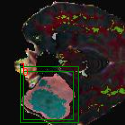

Boxes: tensor([[ 71.0432,  27.4621,  99.8201,  55.8712],
        [ 53.0576,  10.4167, 124.1007,  79.5455],
        [ 68.3453,  27.4621, 103.4173,  59.6591]])
Labels: [0 1 2]
Label: ['0', '1', '2']


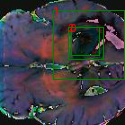

In [118]:
test_data_transformed = PreprocessData(os.path.join(dataset_path, "test"), height = 125, width=125, transforms = validation_data_augmentations())

for i in range(7): 
    image_test, target_test = test_data_transformed[i]
    visualize_one_image(image_test, target_test)

### Exploratory Data Analysis/ Data Visualizations

In [62]:
def visualize_one_image(image, target):
    if not isinstance(image, np.ndarray): image = image.permute(1,2,0).numpy()
        
    image = (255.0 * (image - image.min()) / (image.max() - image.min()))
    boxes = target['boxes']
    labels = target['labels'].numpy()
    label = [str(label) for label in labels] 
    print("Boxes:", boxes)
    print("Labels:", labels)
    print("Label:", label)
    
    pil_image = PILImage.fromarray(np.uint8(image))

    draw = ImageDraw.Draw(pil_image)
    for i, box in enumerate(boxes):
        draw.rectangle([(int(box[0]), int(box[1])), (int(box[2]), int(box[3]))], outline="green")
        draw.text((int(box[0]), int(box[1]) - 5), label[i], fill="red")

    display(pil_image)


Boxes: BoundingBoxes([[ 75.5396,  11.3636, 120.5036,  46.4015],
               [ 66.5468,   4.7348, 124.1007,  54.9242],
               [ 73.7410,   7.5758, 123.2014,  44.5076]], format=BoundingBoxFormat.XYXY, canvas_size=[125, 125])
Labels: [0 1 2]
Label: ['0', '1', '2']


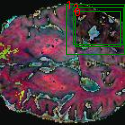

In [63]:
image_test, target_test = training_data_nottransformed[2]
visualize_one_image(image_test, target_test)

Boxes: tensor([[ 75.5396,  11.3636, 120.5036,  46.4015],
        [ 66.5468,   4.7349, 124.1007,  54.9242],
        [ 73.7410,   7.5758, 123.2014,  44.5076]])
Labels: [0 1 2]
Label: ['0', '1', '2']


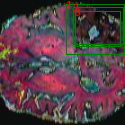

In [64]:
image_test, target_test = training_data_transformed[2]
visualize_one_image(image_test, target_test)

Boxes: tensor([[ 70.1439,  86.1742,  76.4389,  91.8561],
        [ 43.1655,  76.7045,  75.5396, 114.5833],
        [ 64.7482,  83.3333,  78.2374,  93.7500]])
Labels: [0 1 2]
Label: ['0', '1', '2']


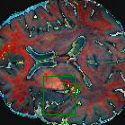

In [65]:
image_test, target_test = training_data_more_transformed[7]
visualize_one_image(image_test, target_test)

## Model Selection

### Model 1: YOLOv8 

In [76]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, ssdlite320_mobilenet_v3_large, retinanet_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import torch.nn as nn
import yolov8
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_yolov8():
    stg = tf.distribute.MirroredStrategy()
    with stg.scope():
        backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")
        
        model = keras_cv.models.YOLOV8Detector(num_classes=3,
                                                bounding_box_format="xyxy",
                                                backbone=backbone, fpn_depth=1 )

        optimizer = AdamW(learning_rate=0.0001, weight_decay=0.004, global_clipnorm = 10)

        model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')
    return model 

model1 = get_yolov8()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Model 2: Faster-RCNN

In [77]:
def get_fasterrcnn():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
    
    return model

model2 = get_fasterrcnn()

### Model 3: Retinanet

In [78]:
def get_retinanet(num_classes):
    model = retinanet_resnet50_fpn_v2(pretrained=True)
    # Further adjustments can be made here after understanding the model structure
    return model

model3 = get_retinanet(3)

/Users/anthonym/.pyenv/versions/3.10.0/envs/mlenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/anthonym/.pyenv/versions/3.10.0/envs/mlenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model 4: SSD

In [79]:
def get_ssd(num_classes):
    model = ssdlite320_mobilenet_v3_large(pretrained=True)
    model.head.classification_head.num_classes = num_classes
    return model

model4 = get_ssd(3)

/Users/anthonym/.pyenv/versions/3.10.0/envs/mlenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_Large_Weights.COCO_V1`. You can also use `weights=SSDLite320_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model 5: EfficientDet

In [80]:
def get_efficientdet(num_classes, model_name='tf_efficientdet_d1'):
    config = get_efficientdet_config(model_name)
    config.num_classes = num_classes
    config.image_size = [512, 512]
    model = EfficientDet(config, pretrained_backbone=True)
    model.class_net = HeadNet(config, num_outputs=config.num_classes)
    return DetBenchTrain(model)

model5 = get_efficientdet(3, 'tf_efficientdet_d1')

In [81]:
models = {
    "model1": model1,
    "model2": model2,
    "model3": model3,
    "model4": model4,
    #"model5": model5,
}

In [82]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## Dataloaders

In [84]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3
train_dataset = PreprocessData(os.path.join(dataset_path, "train"), height=125, width=125, transforms=training_data_augmentations())
train_dataset_more_transformed = PreprocessData(os.path.join(dataset_path, "train"), height = 125, width=125, transforms = training_data_more_augmentations())
valid_dataset = PreprocessData(os.path.join(dataset_path, "valid"), height=125, width=125, transforms=validation_data_augmentations())


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCHSIZE_TRAINLOADER,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

train_loader_aug = torch.utils.data.DataLoader(
    train_dataset_more_transformed,
    batch_size=BATCHSIZE_TRAINLOADER,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=BATCHSIZE_TESTLOADER,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

Processing labels:   0%|          | 0/50 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/50 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/17 [00:00<?, ?it/s]

In [74]:
train_dataset[2]

(tensor([[[0.0431, 0.0428, 0.0413,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0428, 0.0413,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0428, 0.0413,  ..., 0.0431, 0.0431, 0.0431],
          ...,
          [0.0431, 0.0433, 0.0441,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0433, 0.0440,  ..., 0.0431, 0.0431, 0.0431],
          [0.0431, 0.0432, 0.0434,  ..., 0.0431, 0.0431, 0.0431]],
 
         [[0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0510, 0.0510,  ..., 0.0510, 0.0510, 0.0510],
          ...,
          [0.0510, 0.0508, 0.0500,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0508, 0.0502,  ..., 0.0510, 0.0510, 0.0510],
          [0.0510, 0.0509, 0.0508,  ..., 0.0510, 0.0510, 0.0510]],
 
         [[0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ...,

## Model Training

In [44]:
def train_one_epoch(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        images = torch.stack(images)
        images = images.to(device)

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        
    return train_loss_list

In [45]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [51]:
import time 

def train_full(model, num_epochs, save_model_epoch, save_plots_epoch, train_loader, valid_loader):
    # start the training epochs
    for epoch in range(num_epochs):
        print(f"\nEPOCH {epoch+1} of {num_epochs}")
        
        # reset the training and validation loss histories for the current epoch
        train_loss_hist.reset()
        val_loss_hist.reset()
        
        # create two subplots, one for each, training and validation
        figure_1, train_ax = plt.subplots()
        figure_2, valid_ax = plt.subplots()
        
        # start timer and carry out training and validation
        start = time.time()
        train_loss = train_one_epoch(train_loader, model)
        val_loss = validate(valid_loader, model)
        print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
        print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        
        if (epoch+1) % save_model_epoch == 0: # save model after every n epochs
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
            print('SAVING MODEL COMPLETE...\n')
        
        if (epoch+1) % save_plots_epoch == 0: # save loss plots after n epochs
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            print('SAVING PLOTS COMPLETE...')
        
        if (epoch+1) == num_epochs: # save loss plots and model once at the end
            train_ax.plot(train_loss, color='blue')
            train_ax.set_xlabel('iterations')
            train_ax.set_ylabel('train loss')
            valid_ax.plot(val_loss, color='red')
            valid_ax.set_xlabel('iterations')
            valid_ax.set_ylabel('validation loss')
            figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
            figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        plt.close('all')

### Training Model 1

In [80]:
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')
    
    boxes = []
    classes = []
    
    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])
        
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
        
            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)
    
            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)
    
    return img_path, classes, boxes


# a function for creating file paths list 
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


class_ids = ['label0', 'label1', 'label2']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

class_mapping

{0: 'label0', 1: 'label1', 2: 'label2'}

In [82]:
def creating_files(img_files_paths, annot_files_paths):
    
    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)
    
    image_paths = []
    bbox = []
    classes = []
    
    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)
        
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    
    return image_paths, classes, bbox

In [83]:
train_img_paths, train_classes, train_bboxes = creating_files('data/train/images', 
                                                              'data/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('data/valid/images', 
                                                              'data/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('data/test/images', 
                                                            'data/test/labels')

In [84]:
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32) 
    
    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }
    
    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [87]:
BATCH_SIZE = 4
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [1]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv

model = get_yolov8()
hist = model.fit(train_dataset, validation_data = valid_dataset,  epochs = 20)

NameError: name 'yolov8' is not defined

### Training Model 2

In [56]:
os.system("brew install wget")

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
autotrace
beakerlib
beancount-language-server
descope
dpcmd
ffmpeg@6
kubecolor
lexido
liblc3
libtickit
llvm@17
logdy
mdformat
morpheus
oj
parsedmarc
pnpm@8
promptfoo
rustcat
superfile
sysaidmin
uni-algo
uutils-diffutils
==> New Casks
1password-cli@1
1password-cli@beta
1password@7
1password@beta
1password@nightly
ableton-live-intro@11
ableton-live-lite@11
ableton-live-standard@11
ableton-live-suite@11
adguard-vpn@nightly
adguard@nightly
aerial@beta
affinity-designer@1
affinity-photo@1
affinity-publisher@1
alfred@4
android-studio-preview@beta
android-studio-preview@canary
anythingllm
arduino-ide@nightly
arm-performance-libraries
automattic-texts
azure-data-studio@insiders
bbedit@14
beyond-compare@beta
blen

==> Downloading https://ghcr.io/v2/homebrew/core/wget/manifests/1.24.5
==> Fetching dependencies for wget: libunistring and libidn2
==> Downloading https://ghcr.io/v2/homebrew/core/libunistring/manifests/1.2
==> Fetching libunistring
==> Downloading https://ghcr.io/v2/homebrew/core/libunistring/blobs/sha256:4a1c0f956e528e0fe9a5040da6a2002e221024835916fdc198b5d734e3c2638d
==> Downloading https://ghcr.io/v2/homebrew/core/libidn2/manifests/2.3.7
==> Fetching libidn2
==> Downloading https://ghcr.io/v2/homebrew/core/libidn2/blobs/sha256:670f6ed3768acde8ce10b5dcfc88fef69cea994ff84491b253a5e818cd4f9a1b
==> Fetching wget
==> Downloading https://ghcr.io/v2/homebrew/core/wget/blobs/sha256:9befdad158e59763fb0622083974a6252878019702d8c961e1bec3a5f5305339
==> Installing dependencies for wget: libunistring and libidn2
==> Installing wget dependency: libunistring
==> Downloading https://ghcr.io/v2/homebrew/core/libunistring/manifests/1.2
Already downloaded: /Users/anthonym/Library/Caches/Homebrew/dow

0

In [57]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-04-30 00:30:56--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

     0K ...                                                   100% 46.7M=0s

2024-04-30 00:30:57 (46.7 MB/s) - ‘engine.py’ saved [4063/4063]

--2024-04-30 00:30:57--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

0

In [85]:
from engine import train_one_epoch, evaluate

for key,value in models.items():
    
    if key == "model1":
        continue 

    model = value

    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=0.0001,
        momentum=0.95,
        weight_decay=0.0005
    )

    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=2,
        gamma=0.1
    )

    initial_state = {name: param.clone() for name, param in model.named_parameters()}
    initial_state

    train_loss_hist = Averager()
    val_loss_hist = Averager()
    train_itr = 1
    val_itr = 1

    train_loss_list = []
    val_loss_list = []

    MODEL_NAME = key
    
    num_epochs = 50
    for epoch in range(num_epochs):
        print(f"Training {key} \n")
        train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
        lr_scheduler.step()
        evaluate(model, valid_loader, device=device)
        print(f"\n Completed training for {key}")

    #train_full(model, num_epochs=15, save_model_epoch=3, save_plots_epoch=3, train_loader=train_loader, valid_loader=valid_loader)


Training model2 

Epoch: [0]  [0/7]  eta: 0:04:19  lr: 0.000017  loss: 1.1249 (1.1249)  loss_classifier: 0.9036 (0.9036)  loss_box_reg: 0.0911 (0.0911)  loss_objectness: 0.1161 (0.1161)  loss_rpn_box_reg: 0.0140 (0.0140)  time: 37.0960  data: 0.0150
Epoch: [0]  [6/7]  eta: 0:00:30  lr: 0.000100  loss: 1.1339 (1.3186)  loss_classifier: 0.9036 (0.8951)  loss_box_reg: 0.0857 (0.0845)  loss_objectness: 0.1621 (0.2686)  loss_rpn_box_reg: 0.0162 (0.0705)  time: 30.3170  data: 0.0141
Epoch: [0] Total time: 0:03:32 (30.3185 s / it)
creating index...
index created!
Test:  [ 0/17]  eta: 0:00:20  model_time: 1.1668 (1.1668)  evaluator_time: 0.0250 (0.0250)  time: 1.1935  data: 0.0016
Test:  [16/17]  eta: 0:00:01  model_time: 1.2084 (1.2182)  evaluator_time: 0.0024 (0.0035)  time: 1.2229  data: 0.0011
Test: Total time: 0:00:20 (1.2230 s / it)
Averaged stats: model_time: 1.2084 (1.2182)  evaluator_time: 0.0024 (0.0035)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Pre

KeyboardInterrupt: 

### Model Evaluations

In [42]:
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

train_loss_list = []
val_loss_list = []

MODEL_NAME = 'braintumor_objectdetection_fasterrcnn'

In [44]:
train_full(num_epochs=15, save_model_epoch=3, save_plots_epoch=3, train_loader=train_loader, valid_loader=valid_loader)


EPOCH 1 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #0 train loss: 0.770
Epoch #0 validation loss: 0.428
Took 2.961 minutes for epoch 0

EPOCH 2 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #1 train loss: 0.546
Epoch #1 validation loss: 0.484
Took 2.904 minutes for epoch 1

EPOCH 3 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #2 train loss: 0.503
Epoch #2 validation loss: 0.396
Took 2.911 minutes for epoch 2
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 4 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #3 train loss: 0.416
Epoch #3 validation loss: 0.368
Took 3.031 minutes for epoch 3

EPOCH 5 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #4 train loss: 0.399
Epoch #4 validation loss: 0.364
Took 2.984 minutes for epoch 4

EPOCH 6 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #5 train loss: 0.407
Epoch #5 validation loss: 0.332
Took 2.960 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 7 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #6 train loss: 0.416
Epoch #6 validation loss: 0.346
Took 3.097 minutes for epoch 6

EPOCH 8 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #7 train loss: 0.401
Epoch #7 validation loss: 0.340
Took 2.947 minutes for epoch 7

EPOCH 9 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #8 train loss: 0.402
Epoch #8 validation loss: 0.360
Took 2.990 minutes for epoch 8
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 10 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #9 train loss: 0.424
Epoch #9 validation loss: 0.356
Took 3.008 minutes for epoch 9

EPOCH 11 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #10 train loss: 0.482
Epoch #10 validation loss: 0.323
Took 2.941 minutes for epoch 10

EPOCH 12 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #11 train loss: 0.423
Epoch #11 validation loss: 0.310
Took 2.876 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 13 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #12 train loss: 0.398
Epoch #12 validation loss: 0.385
Took 2.967 minutes for epoch 12

EPOCH 14 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #13 train loss: 0.393
Epoch #13 validation loss: 0.398
Took 2.909 minutes for epoch 13

EPOCH 15 of 15
Training


  0%|          | 0/7 [00:00<?, ?it/s]

Validating


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch #14 train loss: 0.412
Epoch #14 validation loss: 0.348
Took 2.893 minutes for epoch 14
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


## Model Selection


In [86]:
model_path = 'data/model9.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [87]:
trained_state = {name: param for name, param in model.named_parameters()}
trained_state

{'backbone.body.conv1.weight': Parameter containing:
 tensor([[[[-6.1102e-03,  9.5599e-03,  3.1568e-02,  ..., -1.4302e-01,
             4.7951e-02,  2.8355e-02],
           [-1.0539e-02, -7.9132e-04,  8.8673e-02,  ..., -3.3262e-01,
             5.0684e-02,  8.0228e-02],
           [ 5.8592e-03, -8.4502e-03,  5.4741e-02,  ..., -4.0573e-01,
            -7.0297e-02,  1.4837e-01],
           ...,
           [ 4.2638e-03,  2.5437e-02, -4.4603e-02,  ..., -1.1729e-01,
            -1.7737e-01,  1.0410e-01],
           [-1.7198e-03, -6.8754e-04, -1.9032e-02,  ..., -3.7532e-02,
            -7.5427e-02,  3.8558e-02],
           [-5.2213e-03, -1.4919e-02, -1.0002e-02,  ..., -2.4140e-02,
            -3.2910e-02, -2.3537e-03]],
 
          [[ 1.3150e-02,  1.9430e-02,  4.7100e-02,  ..., -1.2007e-01,
             4.2042e-02, -2.8360e-03],
           [-7.1702e-03, -4.5080e-03,  9.2422e-02,  ..., -3.1347e-01,
             3.8911e-02,  4.6476e-02],
           [-3.8023e-04, -3.2419e-02,  3.3256e-02,  ...,

In [ ]:
# train_full(num_epochs=50, save_model_epoch=10, save_plots_epoch=10, train_loader=train_loader, valid_loader=valid_loader)

In [88]:
TEST_DIR = 'data/test'


In [90]:
test_dataset = PreprocessData(os.path.join(dataset_path, "test"), height=125, width=125, transforms=validation_data_augmentations())

Processing labels:   0%|          | 0/7 [00:00<?, ?it/s]

In [92]:
PRED_DIR = 'data/pred/'


In [93]:
def save_image(folder, name, image):
    output_path = os.path.join(folder, f"{name}.jpg")
    cv2.imwrite(output_path, image)

In [97]:
def test(testset, detection_threshold = 0.5):
    for i in range(len(testset)):
        tensor_image = testset[i][0]
        image_name = "image_" + str(testset[i][1]['image_id'])
        image = tensor_image.cpu().numpy() * 255
        image = np.array(image, dtype=np.uint8)
        image = np.transpose(image, (1, 2, 0)).astype(np.uint8)

        with torch.no_grad():
            tensor_image = torch.unsqueeze(tensor_image, 0)
            outputs = model(tensor_image.to(device))

        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

        if len(outputs[0]['boxes']) != 0:
            boxes = outputs[0]['boxes'].data.numpy()
            scores = outputs[0]['scores'].data.numpy()
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            draw_boxes = boxes.copy()
            labels = outputs[0]['labels'].numpy()
            pred_classes = [str(label) for label in labels]

            img1 = image.copy()

            for j, box in enumerate(draw_boxes):
                cv2.rectangle(img1,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 2)
                cv2.putText(img1, pred_classes[j],
                            (int(box[0]), int(box[1]-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0),
                            2, lineType=cv2.LINE_AA)
            truthboxes = testset[i][1]['boxes'].numpy().astype(np.int32)
            draw_truthboxes = truthboxes.copy()
            truth_labels = testset[i][1]['labels'].numpy()
            truth_pred_classes = [str(label) for label in truth_labels]
            for k, boxtruth in enumerate(draw_truthboxes):
                cv2.rectangle(img1,
                            (int(boxtruth[0]), int(boxtruth[1])),
                            (int(boxtruth[2]), int(boxtruth[3])),
                            (0, 255, 0), 2)
                cv2.putText(img1, truth_pred_classes[k],
                            (int(boxtruth[0]), int(boxtruth[1]-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0),
                            2, lineType=cv2.LINE_AA)
            save_image(PRED_DIR, image_name, img1)
            print(f"Image {i+1}/{len(testset)} saved successfully.")

    print('TEST PREDICTIONS COMPLETE')


## Model Evaluation

In [119]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [99]:
test(test_dataset)

Image 1/7 saved successfully.
Image 2/7 saved successfully.
Image 3/7 saved successfully.
Image 4/7 saved successfully.
Image 5/7 saved successfully.
Image 6/7 saved successfully.
Image 7/7 saved successfully.
TEST PREDICTIONS COMPLETE


In [104]:
def evaluate_faster_rcnn(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        true_positives = 0
        false_positives = 0
        false_negatives = 0

        for images, targets in test_loader:
            images = list(image for image in images)
            targets = [{k: v for k, v in t.items()} for t in targets]

            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                true_boxes = target['boxes']
                true_labels = target['labels']

                for i, true_box in enumerate(true_boxes):
                    if true_box.dim() == 1: 
                        true_box = true_box.unsqueeze(0)
                    if len(pred_boxes) == 0:
                        false_negatives += 1
                        continue
                    ious = torchvision.ops.box_iou(pred_boxes, true_box)
                    max_ious, max_idx = ious.max(dim=0)
                    for idx, max_iou in enumerate(max_ious):
                        if max_iou >= 0.5 and true_labels[i] == output['labels'][max_idx[idx]] and pred_scores[max_idx[idx]] >= 0.5:
                            true_positives += 1
                            pred_boxes = torch.cat((pred_boxes[:max_idx[idx]], pred_boxes[max_idx[idx] + 1:]))
                            pred_scores = torch.cat((pred_scores[:max_idx[idx]], pred_scores[max_idx[idx] + 1:]))
                        else:
                            false_negatives += 1

                false_positives += len(pred_boxes)

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score


In [120]:
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# precision, recall, f1_score = evaluate_faster_rcnn(model, test_loader, device)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)